In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu
from scipy.stats.mstats import mquantiles

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table, unique

from regions import Regions, CircleSkyRegion

In [2]:
coords_df = pd.read_csv('/Users/ngbinh/Downloads/rafael_data/coordinates.txt', delimiter=' ')
coords_df = coords_df.rename(columns={"Id": "id"})

In [3]:
info_df = pd.read_csv('/Users/ngbinh/Downloads/rafael_data/CIGALE_COSMOSWEB_v3.1.0.dat', delimiter=' ')

In [4]:
# this creates a mega DataFrame 
df = pd.merge(coords_df, info_df, on="id", how="left")

In [5]:
ras = df['alpha'].values
decs = df['delta'].values
redshifts = df['best.universe.redshift'].values

# this creates a SkyCoord object of all the objects' RAs and Decs, so we can loop through them later.
all_objects = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)

In [6]:
### from the arrays of RA and Dec, pick a random pair of RA and Dec and find their neighbors within a specified
### aperture. do this 1000 times, then save the number of neighbors from each time into an array.

# this creates an array of search radii
radii_array = np.arange(1, 16, 2)

# this creates an empty list of neighbor numbers for each iteration over search radii to add into
all_numbers_of_neighbors = []
cdfs = []

# this is the loop that goes through each search radius
for search_radius in radii_array:

    # this creates an empty array to save the number of neighbors for each run with each search radius
    number_of_neighbors = np.zeros(1000)
        
    # this for-loop is to run the code 1000 times
    for i in range(1000):
        # use np.random.uniform to find a random RA and Dec within our given boundaries
        random_ras = np.random.uniform(np.min(ras), np.max(ras))
        random_decs = np.random.uniform(np.min(decs), np.max(decs))
        
        # turn the randomly generated RA and Dec into coords to find neighbors for
        random_coords = SkyCoord(ra=random_ras*u.degree, dec=random_decs*u.degree)
        
        # now, we search for all the neighbors of these random coordinates, within a given distance
        d2d = random_coords.separation(all_objects)
        catalog_mask = d2d < search_radius*u.arcsec
    
        neighbor_ras = ras[catalog_mask]
        neighbor_zs = redshifts[catalog_mask]
        
        # final selection of galaxies, which should have redshift within 3 and 4
        final_ras = neighbor_ras[(neighbor_zs >= 3) & (neighbor_zs <= 4)]
    
        # this saves the number of neighbors identified in each run into the array we've made above
        number_of_neighbors[i] = np.size(final_ras)

    count, bins_count = np.histogram(number_of_neighbors, bins=100)
    pdf = count / np.sum(count) 
    cdf = np.cumsum(pdf) 

    print(search_radius)
    
    all_numbers_of_neighbors.append(number_of_neighbors)
    cdfs.append(cdf)

1
3
5
7
9
11
13
15


In [7]:
all_numbers_of_neighbors = np.array(all_numbers_of_neighbors, dtype='object')
cdfs = np.array(cdfs, dtype='object')

In [8]:
print(all_numbers_of_neighbors)
print(np.shape(all_numbers_of_neighbors))

[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [2.0 2.0 0.0 ... 0.0 4.0 1.0]
 [2.0 0.0 6.0 ... 0.0 0.0 0.0]
 [8.0 0.0 0.0 ... 7.0 0.0 0.0]]
(8, 1000)


In [9]:
all_radii_means = np.zeros(np.size(radii_array))
all_radii_percentile = []

for x in range(np.size(radii_array)):
    case = all_numbers_of_neighbors[x]
    cdf = cdfs[x]
#    print(mquantiles(case, prob=[0.16, 0.50, 0.84]))
    all_radii_means[x]=np.mean(case)
    all_radii_percentile.append(mquantiles(cdf, prob=[0.16, 0.50, 0.84]))

In [10]:
### now, look through the 9 QGs and their identified neighbors. do the same thing as we did earlier.
host_info = pd.read_csv('basic_data.txt', delimiter=' ', names=['name', 'RA', 'Dec', 'spec_z'])
host_ra_arr = host_info['RA'].values
host_dec_arr = host_info['Dec'].values
how_many_galaxies = np.size(host_ra_arr)

tentative = pd.read_csv('potential_neighbors.txt', sep='\t')

In [11]:
all_radii_percentile

[array([0.9949999999999999, 0.995, 0.9950000000000001], dtype=object),
 array([0.939, 0.964, 0.9889999999999999], dtype=object),
 array([0.847, 0.9755, 0.999], dtype=object),
 array([0.893, 0.9870000000000001, 0.9990000000000001], dtype=object),
 array([0.806, 0.9590000000000001, 0.9950000000000001], dtype=object),
 array([0.676, 0.9410000000000001, 0.9970000000000001], dtype=object),
 array([0.6762239999999998, 0.9515, 0.9990000000000001], dtype=object),
 array([0.6040159999999999, 0.9020000000000001, 0.9940000000000002],
       dtype=object)]

In [12]:
# this creates an empty list of real neighbor numbers for each iteration over search radii to add into
all_numbers_of_real_neighbors = []

# this loops through each search radius
for search_radius in radii_array:

    # this creates an empty array to save the number of neighbors for each run with each search radius
    number_of_real_neighbors = np.zeros(how_many_galaxies)
    
    # this loops through the 9 QGs
    for galaxy_number in range(how_many_galaxies):
        # this retrieves the RA and Dec of each QG
        host_ra = host_ra_arr[galaxy_number]
        host_dec = host_dec_arr[galaxy_number]    
    
        tentative_ra = tentative[tentative['host_ra']==host_ra]['ra'].values
        tentative_dec = tentative[tentative['host_ra']==host_ra]['dec'].values
    
        host_coords = SkyCoord(ra=host_ra*u.degree, dec=host_dec*u.degree)
        tentative_objects = SkyCoord(ra=tentative_ra*u.degree, dec=tentative_dec*u.degree)

        # now, we search for all the neighbors of these random coordinates, within a given distance
        d2d = host_coords.separation(tentative_objects)
        catalog_mask = d2d < search_radius*u.arcsec
        neighbor_ras = tentative_ra[catalog_mask]
    
        # this saves the number of neighbors identified in each run into the array we've made above
        number_of_real_neighbors[galaxy_number] = np.size(neighbor_ras)

    all_numbers_of_real_neighbors.append(number_of_real_neighbors)

In [13]:
all_numbers_of_real_neighbors = np.array(all_numbers_of_real_neighbors, dtype='object')

In [14]:
real_raw_data = np.zeros(np.size(radii_array))
real_radii_means = np.zeros(np.size(radii_array))
real_radii_stdev = np.zeros(np.size(radii_array))

for y in range(np.size(radii_array)):
    case = all_numbers_of_real_neighbors[y]
    real_raw_data[y] = np.sum(case)
    real_radii_means[y] = np.mean(case)
    real_radii_stdev[y] = np.std(case)

In [15]:
all_radii_percentile=np.array(all_radii_percentile, dtype='object')
y16 = all_radii_percentile[:,0]
y50 = all_radii_percentile[:,1]
y84 = all_radii_percentile[:,2]

In [16]:
# this looks through the DREAM catalog
dream_df = pd.read_csv('DREaM_quenched_and_nbrs.csv').iloc[:, 1:]
dream_df

,ID,RA,Dec,redshift,M_gal,host_ID,host_RA,host_Dec,host_redshift
0,14629508,0.445640,-0.384444,2.137441,3.422344e+09,14698440.0,0.447830,-0.381314,2.250043
1,14698423,0.447763,-0.379781,2.249653,2.339114e+09,14698440.0,0.447830,-0.381314,2.250043
2,16821150,0.451475,-0.382600,2.584105,1.181753e+09,14698440.0,0.447830,-0.381314,2.250043
3,14547865,-0.340940,0.470701,2.178087,1.774652e+10,14547846.0,-0.339924,0.471336,2.178209
4,14834152,0.107662,-0.381979,2.234976,1.396774e+10,15609351.0,0.106993,-0.381009,2.405133
...,...,...,...,...,...,...,...,...,...
390,16426581,0.067216,0.431446,2.499589,1.042892e+10,16426579.0,0.068834,0.433229,2.499460
391,16426582,0.068995,0.434319,2.499446,3.219762e+09,16426579.0,0.068834,0.433229,2.499460
392,24643402,-0.107376,-0.335341,4.682645,1.024374e+09,25156450.0,-0.109569,-0.332256,4.999670
393,24896123,-0.113403,-0.331330,4.519210,1.503975e+09,25156450.0,-0.109569,-0.332256,4.999670


In [17]:
# this finds the separation between each neighbor and its host
d2d_list = []

for row_number in range(dream_df.shape[0]):
    row = dream_df.iloc[row_number]

    simul_host = SkyCoord(ra=row['host_RA']*u.degree, dec=row['host_Dec']*u.degree)
    simul_nbr = SkyCoord(ra=row['RA']*u.degree, dec=row['Dec']*u.degree)
    
    d2d = simul_host.separation(simul_nbr)
    d2d_list.append(d2d.arcsecond)

dream_df = dream_df.assign(sep=d2d_list)

In [18]:
simul_data_means = np.zeros(np.size(radii_array))

# this loops through each search radius
for radius_idx in range(np.size(radii_array)):

    search_r = radii_array[radius_idx]

    # this finds all the neighbors within the search radius from the host QG
    set = dream_df[dream_df['sep']*u.arcsecond < search_r*u.arcsec]

    # this retrieves how many QGs pass this criteria
#    sample_size = np.size(np.unique(set['host_ID']))
#    print(sample_size)

    # this retrieves how many neighbors pass this criteria
    total_number_of_neighbors = np.size(np.unique(set['ID']))

    # this saves the average number of neighbors into simul_data
    simul_data_means[radius_idx] = total_number_of_neighbors / np.size(np.unique(dream_df['host_ID']))

In [19]:
simul_data_means

array([0.17525773, 0.59793814, 1.12371134, 1.63917526, 2.16494845,
       2.68041237, 3.30927835, 4.01030928])

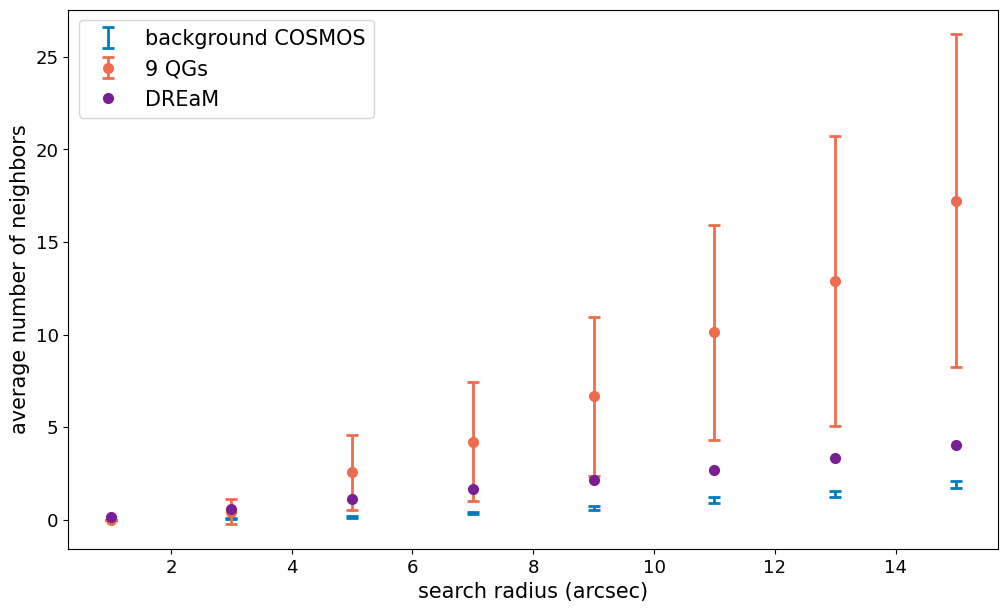

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.errorbar(radii_array, all_radii_means, yerr=(np.abs(y50-y16), np.abs(y84-y50)), capsize=4, 
             color='#007CBE', label='background COSMOS', zorder=1, fmt='none', linewidth=2, markeredgewidth=2)
plt.errorbar(radii_array, real_radii_means, real_radii_stdev, capsize=4, color='#EE6C4D', label='9 QGs', 
             fmt='o', linewidth=2, markeredgewidth=2)
plt.errorbar(radii_array, simul_data_means, capsize=4, color='#791E94', label='DREaM', 
             fmt='o', linewidth=2, markeredgewidth=2)
plt.legend(fontsize=15)
plt.xlabel('search radius (arcsec)', fontsize=15)
plt.ylabel('average number of neighbors', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

fig = fig.savefig('centipede_plot.png')